<a href="https://colab.research.google.com/github/Lysandre-lbd/IA_embarquee_repo/blob/main/TP_IA_EMBARQUEE_BAYDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**QUESTION:** Load dataset and display some lines of the csv file.

In [16]:
from google.colab import drive
drive.mount('/content/drive')
# Chargement du fichier CSV
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ai4i2020.csv')

# Affichage des 5 premières lignes
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

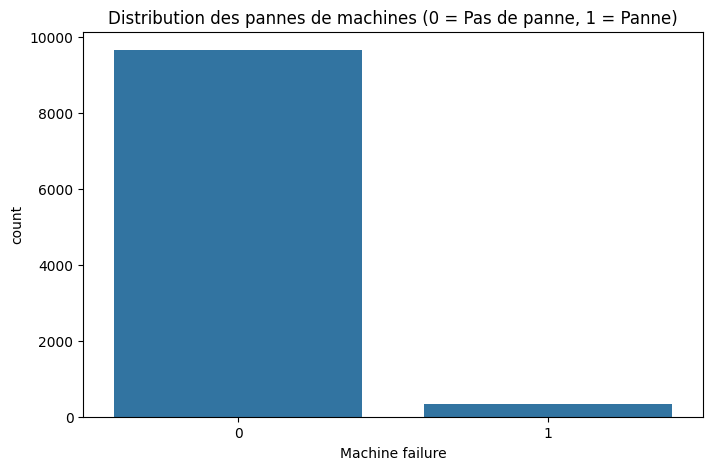

Machine failure
0    9661
1     339
Name: count, dtype: int64


In [17]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Machine failure')
plt.title('Distribution des pannes de machines (0 = Pas de panne, 1 = Panne)')
plt.show()

# Calcul des valeurs exactes pour l'analyse
print(df['Machine failure'].value_counts())

**ANALYSIS QUESTION:** What do you observe?

On observe un déséquilibre de classes important. La grande majorité des instances (9661 sur 10000) correspond à un fonctionnement normal, tandis qu'une très petite partie correspond à des pannes (339).

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Le modèle risque d'être fortement biaisé. Il pourrait prédire "pas de panne" tout le temps et obtenir une précision (accuracy) de 96,6%, tout en étant incapable de détecter les pannes réelles. L'apprentissage sera difficile pour la classe minoritaire car le modèle n'aura pas assez d'exemples pour généraliser les caractéristiques d'une panne.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

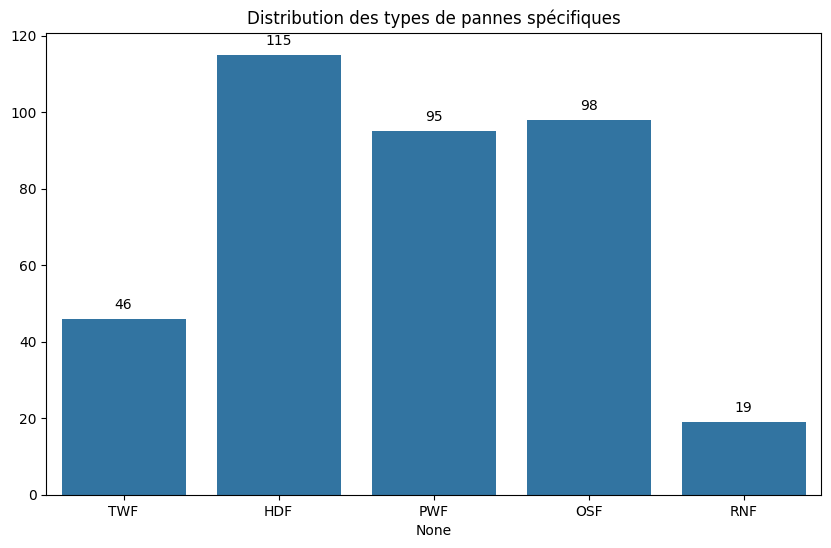

In [18]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
counts = df[failure_types].sum()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=counts.index, y=counts.values)
plt.title('Distribution des types de pannes spécifiques')

# Ajout des valeurs au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Les pannes sont non seulement rares, mais leur distribution par type est également inégale. Par exemple, les pannes de type 'RNF' (Random Failures) sont extrêmement peu fréquentes par rapport aux autres.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

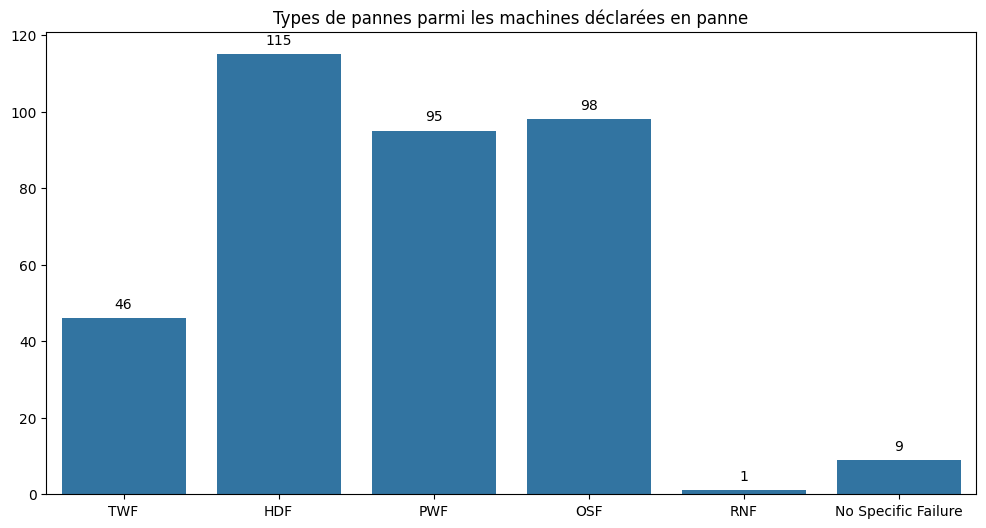

In [19]:
# Filtrer les machines en panne
failed_machines = df[df['Machine failure'] == 1]

# Calculer la somme pour chaque type
failure_counts = failed_machines[failure_types].sum()

# Calculer les machines avec 'Machine failure' à 1 mais aucun type spécifique coché
# Une machine peut avoir plusieurs types de pannes, donc on vérifie si la somme des colonnes est 0
no_specific = failed_machines[(failed_machines[failure_types].sum(axis=1) == 0)].shape[0]

# Ajouter au dictionnaire
all_counts = failure_counts.to_dict()
all_counts['No Specific Failure'] = no_specific

# Graphique
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(all_counts.keys()), y=list(all_counts.values()))
plt.title('Types de pannes parmi les machines déclarées en panne')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

On remarque qu'il existe un nombre significatif de machines marquées comme "en panne" (Machine failure = 1) mais qui n'ont aucun des 5 types de pannes spécifiques activés. On peut en conclure que la colonne Machine failure est l'indicateur global de panne, mais qu'elle ne dépend pas uniquement de la présence de l'un des 5 types listés (il peut y avoir d'autres causes non répertoriées).

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Inputs (X) : Nous utiliserons Type (à encoder), Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], et Tool wear [min]. Ce sont les données capteurs qui décrivent l'état physique de la machine. Nous excluons UDI et Product ID qui sont des identifiants uniques sans valeur prédictive.

Outputs (y) : La cible principale est Machine failure pour la détection binaire. Cependant, pour répondre à la question "quel genre de panne", on pourrait utiliser les 5 colonnes de types de pannes comme une cible multi-label.

Justification : Les résultats précédents montrent que la détection doit se faire en deux temps ou sur un vecteur complet, car la simple présence d'une panne ne garantit pas la connaissance de son type exact. Pour l'IA embarquée, minimiser le nombre d'entrées (en enlevant les IDs) est crucial pour économiser la mémoire de la cible STM32.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**QUESTION** Code below the model architecture

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"